In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

TRAINED_PPO = "/agent_opt_ppo_features"

GRAPH_TITLE = "PPO Trained 2009-2021, Two Million Time Steps Checkpoint"
# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()


INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (5646, 8)
Successfully added technical indicators
Successfully added turbulence index


# Portfolio Optimization Algorithm

In [2]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.44967348 0.30646708 0.48665761 0.34385037 0.32998065 0.31500104
 0.28853749 0.2781374  0.28311105 0.35018996 0.28479142 0.32734885
 0.37702692 0.3591673  0.49457685 0.30874429 0.4419601  0.44753717
 0.55705992 0.33337465 0.26140776 0.28204132 0.26416194 0.23752298
 0.22372669 0.24091322 0.22921621 0.2017071  0.18873202 0.252844
 0.30726287 0.303931   0.27509987 0.32608395 0.49665197 0.3484371
 0.46504188 0.51638148 0.36496779 0.32088908 0.35448204 0.55904059
 0.48251113 0.48442528 0.40644484 0.35127192 0.32329149 0.27646896
 0.28995804 0.36157881 0.35123834 0.38041213 0.58224413 0.35117464
 0.29957051 0.27780384 0.31016923 0.29519025 0.2536062  0.26883371
 0.37129358 0.23562547 0.27818259 0.25157313 0.26191391 0.27878947
 0.334777   0.28687093 0.286389

In [3]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_21172\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [4]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1256422.125
Final accumulative portfolio value: 1.256422125
Maximum DrawDown: -0.29080818292855215
Sharpe ratio: 0.41613374578775886


In [5]:
print(df_opt)

     opt_net_worth       Date
0     1.000000e+06 2021-02-08
1     1.001841e+06 2021-02-09
2     9.961553e+05 2021-02-10
3     1.004593e+06 2021-02-11
4     1.008616e+06 2021-02-12
..             ...        ...
912   1.247720e+06 2024-09-24
913   1.249554e+06 2024-09-25
914   1.254603e+06 2024-09-26
915   1.257822e+06 2024-09-27
916   1.256422e+06 2024-09-30

[917 rows x 2 columns]


In [6]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2021-02-08 00:00:00
2024-09-30 00:00:00


# PPO On portfolio Opt

In [7]:

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta

# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df


environment_ppo = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low", 'macd',
            'rsi_30',
            'cci_30',
            'dx_30'],
    normalize_df=None
)

In [8]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 

In [9]:
# from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt.loc[len(df_ppo_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1502761.75
Final accumulative portfolio value: 1.50276175
Maximum DrawDown: -0.2467424503040333
Sharpe ratio: 0.7166346852333665
hit end!
     ppo_opt_net_worth       Date
0          1000000.000 2021-02-08
1          1006836.375 2021-02-09
2           997191.000 2021-02-10
3           999222.000 2021-02-11
4          1001232.250 2021-02-12
..                 ...        ...
912        1499587.250 2024-09-24
913        1511668.875 2024-09-25
914        1495632.500 2024-09-26
915        1488989.750 2024-09-27
916        1502761.750 2024-09-30

[917 rows x 2 columns]


In [10]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2021-02-08 00:00:00')

In [11]:
df_opt.loc[0,'Date']

Timestamp('2021-02-08 00:00:00')

# Porfolio Baselines

In [12]:
# CRP 

CRP_results = {
    "test": {},
}

environment_ppo.reset()
agent_crp = DRLStableAgent(env = environment_ppo)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_ppo)
CRP_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_ppo._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1256471.25
Final accumulative portfolio value: 1.25647125
Maximum DrawDown: -0.29081622826563613
Sharpe ratio: 0.4161745882119857
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2021-02-08
1         1.001841e+06 2021-02-09
2         9.961551e+05 2021-02-10
3         1.004593e+06 2021-02-11
4         1.008616e+06 2021-02-12
..                 ...        ...
912       1.247768e+06 2024-09-24
913       1.249602e+06 2024-09-25
914       1.254652e+06 2024-09-26
915       1.257872e+06 2024-09-27
916       1.256471e+06 2024-09-30

[917 rows x 2 columns]


In [13]:
# BAH

BAH_results = {
    "test": {},
}

environment_ppo.reset()
agent_bah = DRLStableAgent(env = environment_ppo)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_ppo)
BAH_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_ppo._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1309026.5
Final accumulative portfolio value: 1.3090265
Maximum DrawDown: -0.28406315966747675
Sharpe ratio: 0.4854177371657769
hit end!
     bah_opt_net_worth       Date
0          1000000.000 2021-02-08
1          1001841.375 2021-02-09
2           996124.625 2021-02-10
3          1004572.750 2021-02-11
4          1008652.375 2021-02-12
..                 ...        ...
912        1300096.625 2024-09-24
913        1300434.125 2024-09-25
914        1300635.000 2024-09-26
915        1302343.250 2024-09-27
916        1309026.500 2024-09-30

[917 rows x 2 columns]


In [14]:
# OLMAR

OLMAR_results = {
    "test": {},
}

# OLMAR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }


environment_ppo.reset()
agent_olmar = DRLStableAgent(env = environment_ppo)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_ppo)
OLMAR_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_ppo._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 512611.15625
Final accumulative portfolio value: 0.51261115625
Maximum DrawDown: -0.6402706891743786
Sharpe ratio: -0.3536407165158314
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2021-02-08
1           1.001841e+06 2021-02-09
2           9.852988e+05 2021-02-10
3           9.900919e+05 2021-02-11
4           1.006845e+06 2021-02-12
..                   ...        ...
912         5.040679e+05 2024-09-24
913         4.972510e+05 2024-09-25
914         5.010501e+05 2024-09-26
915         5.074679e+05 2024-09-27
916         5.126112e+05 2024-09-30

[917 rows x 2 columns]


In [15]:
# RMR

RMR_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_rmr = DRLStableAgent(env = environment_ppo)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_ppo)
RMR_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_ppo._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1121254.75
Final accumulative portfolio value: 1.12125475
Maximum DrawDown: -0.40826290014364297
Sharpe ratio: 0.2509346149066576
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2021-02-08
1         1.001841e+06 2021-02-09
2         9.852988e+05 2021-02-10
3         9.900919e+05 2021-02-11
4         1.006845e+06 2021-02-12
..                 ...        ...
912       1.118310e+06 2024-09-24
913       1.125971e+06 2024-09-25
914       1.123887e+06 2024-09-26
915       1.115314e+06 2024-09-27
916       1.121255e+06 2024-09-30

[917 rows x 2 columns]


In [16]:
# BNN

BNN_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_bnn = DRLStableAgent(env = environment_ppo)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_ppo)
BNN_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_ppo._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 921187.9375
Final accumulative portfolio value: 0.9211879375
Maximum DrawDown: -0.45255054092990843
Sharpe ratio: 0.04345614845397759
hit end!
     bnn_opt_net_worth       Date
0         1000000.0000 2021-02-08
1         1000000.0000 2021-02-09
2         1000000.0000 2021-02-10
3         1000000.0000 2021-02-11
4         1000000.0000 2021-02-12
..                 ...        ...
912        918768.9375 2024-09-24
913        925062.8125 2024-09-25
914        923350.1875 2024-09-26
915        916306.8750 2024-09-27
916        921187.9375 2024-09-30

[917 rows x 2 columns]


In [17]:
# SCRP

HISTORY_START_DATE = TRAIN_START_DATE
HISTORY_END_DATE = TRAIN_END_DATE

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = HISTORY_END_DATE,
                     ticker_list = PORT).fetch_data()


history_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(history_df)

SCRP_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

environment_ppo.reset()
agent_scrp = DRLStableAgent(env = environment_ppo)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_ppo)
SCRP_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_ppo._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.06618093 0.0643527  0.05127709]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Se

Shape of DataFrame:  (17754, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 25838412.0
Final accumulative portfolio value: 25.838412
Maximum DrawDown: -0.4379717531755939
Sharpe ratio: 1.1155127993986267
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1735882.75
Final accumulative portfolio value: 1.73588275
Maximum DrawDown: -0.30912734626867044
Sharpe ratio: 0.697849434666388
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2021-02-08
1          9.934260e+05 2021-02-09
2          9.888978e+05 2021-02-10
3          9.869988e+05 2021-02-11
4          9.887514e+05 2021-02-12
..                  ...        ...
912        1.693938e+06 2024-09-24
913        1.686488e+06 2024-09-25
914        1.695056e+06 2024-09-26
915        1.697068e+06 2024-09-27
916        1.735883e+06 2024-09-30

[917 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [18]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_ppo.reset()
agent_bcrp= DRLStableAgent(env = environment_ppo)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_ppo)
BCRP_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_ppo._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1832272.0
Final accumulative portfolio value: 1.832272
Maximum DrawDown: -0.3714848188570874
Sharpe ratio: 0.7632677420802739
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2021-02-08
1          1.005361e+06 2021-02-09
2          1.001443e+06 2021-02-10
3          1.008331e+06 2021-02-11
4          1.010393e+06 2021-02-12
..                  ...        ...
912        1.827460e+06 2024-09-24
913        1.839979e+06 2024-09-25
914        1.836573e+06 2024-09-26
915        1.822564e+06 2024-09-27
916        1.832272e+06 2024-09-30

[917 rows x 2 columns]


# Stock environment optimization algorithm

In [19]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (916, 8)
Annual return          0.085658
Cumulative returns     0.348159
Annual volatility      0.142850
Sharpe ratio           0.647472
Calmar ratio           0.390404
Stability              0.338388
Max drawdown          -0.219408
Omega ratio            1.116763
Sortino ratio          0.923348
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989221
Daily value at risk   -0.017630
dtype: float64
df_dji:            date           dji
0   2021-02-08  1.000000e+06
1   2021-02-09  9.996836e+05
2   2021-02-10  1.001658e+06
3   2021-02-11  1.001432e+06
4   2021-02-12  1.002314e+06
..         ...           ...
912 2024-09-24  1.344821e+06
913 2024-09-25  1.335470e+06
914 2024-09-26  1.343766e+06
915 2024-09-27  1.348159e+06
916 2024-09-30           NaN

[917 rows x 2 columns]
df_dji:                       dji
date                    
2021-02-08  1.000000e+06
2021-02-09  9.996836e+05
2021-02-10  1.001658e+06
2021-02-11  1.001432e+06

# Compare all results

In [20]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')




print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2021-02-08  1.000000e+06
2021-02-09  9.996836e+05
2021-02-10  1.001658e+06
2021-02-11  1.001432e+06
2021-02-12  1.002314e+06
...                  ...
2024-09-24  1.344821e+06
2024-09-25  1.335470e+06
2024-09-26  1.343766e+06
2024-09-27  1.348159e+06
2024-09-30           NaN

[917 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2021-02-08        1.000000e+06        1000000.000   
1         1.001841e+06 2021-02-09        1.005361e+06        1001841.375   
2         9.961551e+05 2021-02-10        1.001443e+06         996124.625   
3         1.004593e+06 2021-02-11        1.008331e+06        1004572.750   
4         1.008616e+06 2021-02-12        1.010393e+06        1008652.375   
..                 ...        ...                 ...                ...   
912       1.247768e+06 2024-09-24        1.827460e+06        1300096.625   
913       1.249602e+06 2024-09-25        1.

# Baseline CRP in the environment

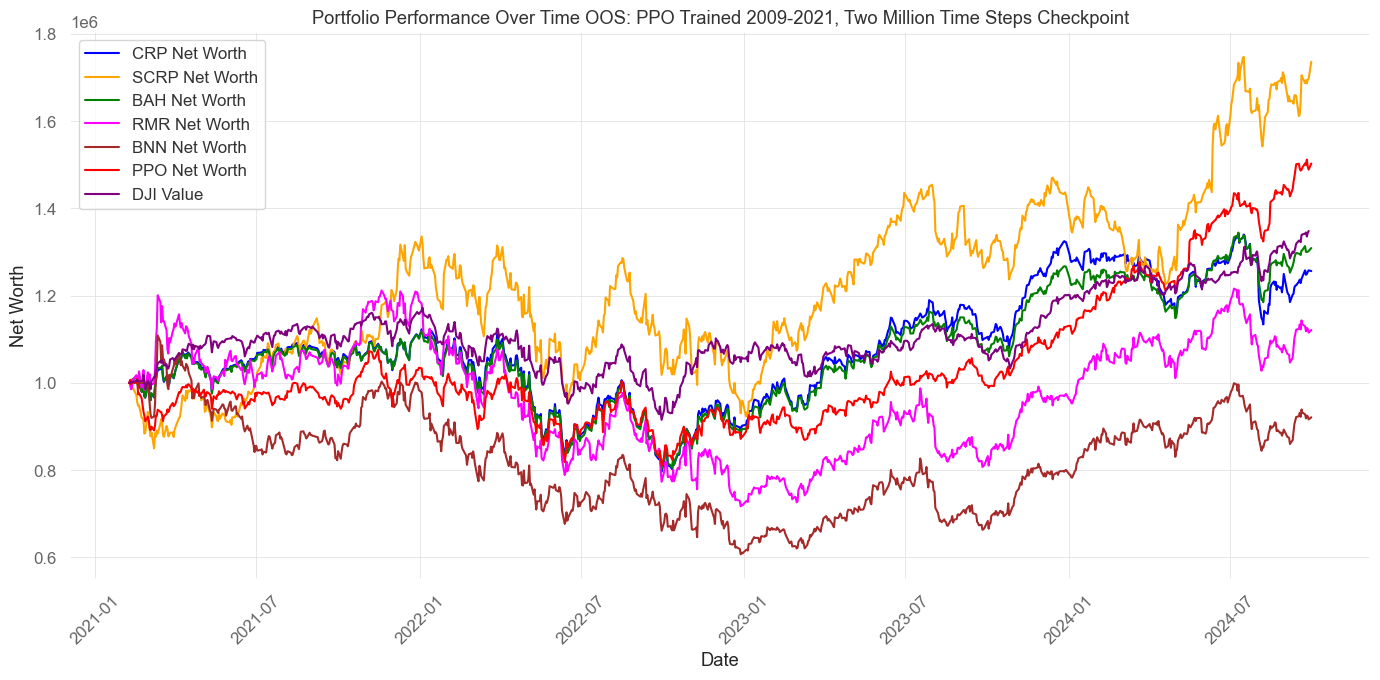

In [21]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'PPO Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}




plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Net Worth', color=color_map['PPO Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 1309026.5,
 'BCRP OPT': 1832272.0,
 'BNN': 921187.9375,
 'CRP': 1256471.25,
 'OLMAR': 512611.15625,
 'PPO': 1502761.75,
 'RMR': 1121254.75,
 'SCRP': 1735882.75}


In [23]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()

  

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 0.3801481828015495,
 'BCRP': 0.6878252978897114,
 'BNN': -0.03324907696345684,
 'CRP': 0.3153359469758196,
 'OLMAR': -0.41173714839899306,
 'PPO': 0.6050049185543925,
 'RMR': 0.17564914836420945,
 'SCRP': 0.6238897389812385}


In [24]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.28406315966747675,
 'BCRP': -0.3714848188570874,
 'BNN': -0.45255054092990843,
 'CRP': -0.29081622826563613,
 'OLMAR': -0.6402706891743786,
 'PPO': -0.2467424503040333,
 'RMR': -0.40826290014364297,
 'SCRP': -0.30912734626867044}


In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df         F    PR(>F)
Portfolio  0.000009     1.0  0.069389  0.792258
Residual   0.246141  1830.0       NaN       NaN


In [26]:
merged_df['ppo_opt_daily_return']

0           NaN
1      0.006836
2     -0.009580
3      0.002037
4      0.002012
         ...   
912   -0.002307
913    0.008057
914   -0.010608
915   -0.004441
916    0.009249
Name: ppo_opt_daily_return, Length: 917, dtype: float64

In [27]:
from scipy import stats

df_ppo = merged_df['ppo_opt_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.001841
2     -0.005706
3      0.008481
4      0.004061
5      0.002875
         ...   
912   -0.010243
913    0.000260
914    0.000154
915    0.001313
916    0.005132
Name: BAH_opt_daily_return, Length: 916, dtype: float64
t-statistic: 0.2634176533100396
p-value: 0.792258341438516
